In [16]:
import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data

import matplotlib.pyplot as plt

In [17]:
torch.__version__

'1.9.1+cu111'

In [18]:
torch.cuda.is_available()
use_gpu = torch.cuda.is_available()

In [19]:
device = torch.device('cuda')
torch.manual_seed(42)

In [20]:
train_data = torchvision.datasets.FashionMNIST(
        root = './data',
        download = True,
        train = True,
        transform=torchvision.transforms.ToTensor()
    )

test_data = torchvision.datasets.FashionMNIST(
        root = './data',
        download = True,
        train = False,
        transform=torchvision.transforms.ToTensor()
    )
# Hyper Parameters
# EPOCH = 3               # train the training data n times, to save time, we just train 1 epoch


In [21]:
# plot one example
print(train_data.train_data.size()),print(train_data.train_labels.size())
print(test_data.test_data.size()),print(train_data.test_labels.size())

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([60000])


d:\programs\envs\python38\lib\site-packages\torchvision\datasets\mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
d:\programs\envs\python38\lib\site-packages\torchvision\datasets\mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
d:\programs\envs\python38\lib\site-packages\torchvision\datasets\mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
d:\programs\envs\python38\lib\site-packages\torchvision\datasets\mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


(None, None)

In [22]:
train_data.train_labels.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

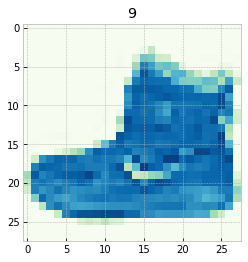

In [23]:
idx = 0
plt.imshow(train_data.train_data[idx].numpy(), cmap='GnBu')
plt.title('%i' % train_data.train_labels[idx])
plt.show()

In [35]:
class CNN(nn.Module):
    def __init__(self, conv1_out=6):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=conv1_out,     # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (6, 28, 28)  28-5+1+2*2=28
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2)     # choose max value in 2x2 area, output shape (6, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (6, 14, 14)
            nn.Conv2d(conv1_out, 16, 5, 1, 0),      # output shape (16, 10, 10) 14-5+1+2*0=10
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2)                 # output shape (16, 5, 5)
        )
        
        self.conv3 = nn.Sequential(         # input shape (16, 5, 5)
            nn.Conv2d(16, 120, 5, 1, 0),    # output shape (120, 1, 1) 5-5+1+2*0=1
            nn.ReLU()                       # activation
        )
        
        self.fc1 = nn.Sequential(            # input shape (1, 5, 5)
            nn.Linear(120, 84),             # output shape (84)
            nn.ReLU(),                      # activation
        )
        
        self.fc2 = nn.Sequential(            # input shape (1, 5, 5)
            nn.Linear(84, 10),               # output shape (10)
            nn.LogSoftmax(dim = -1)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, **)
        x = self.fc1(x)
        output = self.fc2(x)

        return output, x                    # return x for visualization

In [25]:
def data_preparation(train_data=train_data, test_data=test_data, batch_size=50):
    train_loader = Data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
    test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(torch.FloatTensor)/255.   
    test_y = test_data.test_labels
    ada_epoch = (batch_size * 20000) // len(train_data)
    return train_loader, test_x.cuda(), test_y.cuda(), ada_epoch


In [26]:
def modeling(conv1_out=6, lr=0.001):
    model = CNN(conv1_out=conv1_out)
    model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)   # optimize all cnn parameters
    loss_func = nn.CrossEntropyLoss()
    loss_func = loss_func.cuda()                              # the target label is not one-hotted
    return model, optimizer, loss_func

In [27]:
# training and testing
def train(train_loader, test_x, test_y, model, optimizer, loss_func, ada_epoch):
    loss_arr = []
    accu_arr = []
    for epoch in range(ada_epoch):
        for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
            b_x = Variable(x)   # batch x
            b_y = Variable(y)   # batch y
            if use_gpu:
                b_x = b_x.cuda()
                b_y = b_y.cuda()
            output = model(b_x)[0]            # cnn output
            loss = loss_func(output, b_y)   # cross entropy loss
            optimizer.zero_grad()           # clear gradients for this training step
            loss.backward()                 # backpropagation, compute gradients
            optimizer.step()                # apply gradients
            loss = loss.item()
            
            if step % 100 == 0:
                test_output, last_layer = model(test_x)
                pred_y = torch.max(test_output, 1)[1].data.squeeze()
                accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
                loss_arr.append(loss)
                accu_arr.append(accuracy)
                print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.4f' % accuracy)
                
    return loss_arr, accu_arr, model


In [28]:
def training_plot(multi_loss_arr, multi_accu_arr, plot_name):
    plt.style.use('bmh')
    plt.figure(dpi=300)
    plt.title('Training Process')    
    for i in range(len(multi_accu_arr)):
        loss_arr = multi_loss_arr[i]
        accu_arr = multi_accu_arr[i]
        plt.plot(range(len(loss_arr)), loss_arr, label='loss{}'.format(i),linewidth=0.7)
        plt.plot(range(len(accu_arr)), accu_arr, label='accu{}'.format(i),linewidth=0.7)
    plt.yticks([0.05*i for i in range(21)])
    plt.ylim([0,1])
    plt.legend()
    plt.savefig('./pics/{}.jpg'.format(plot_name))

In [36]:
def exp_batch(batch_size_arr, plot_name='test00'):
    multi_loss_arr = []
    multi_accu_arr = []
    model_arr = []
    for batch_size in batch_size_arr:
        train_loader, test_x, test_y, ada_epoch = data_preparation(batch_size=batch_size)
        model, optimizer, loss_func = modeling()
        loss_arr, accu_arr, model = train(train_loader, test_x, test_y, model, optimizer, loss_func, ada_epoch)
        multi_loss_arr.append(loss_arr)
        multi_accu_arr.append(accu_arr)
        model_arr.append(model)
    training_plot(multi_loss_arr, multi_accu_arr, plot_name)
    final_accu = multi_accu_arr[:][-1]
    return model_arr, final_accu

In [ ]:
batch_model_arr, batch_final_accu = exp_batch(batch_size_arr=[50,100,150],plot_name='batch_test(50,100,150)')

In [38]:
def exp_conv1_out(conv1_out_arr=[8,16,24], plot_name='test01'):
    multi_loss_arr = []
    multi_accu_arr = []
    model_arr = []
    for conv1_out in conv1_out_arr:
        train_loader, test_x, test_y, ada_epoch = data_preparation(batch_size=100)
        model, optimizer, loss_func = modeling(conv1_out=conv1_out)
        loss_arr, accu_arr, model = train(train_loader, test_x, test_y, model, optimizer, loss_func, ada_epoch)
        multi_loss_arr.append(loss_arr)
        multi_accu_arr.append(accu_arr)
        model_arr.append(model)
    training_plot(multi_loss_arr, multi_accu_arr, plot_name)
    final_accu = multi_accu_arr[:][-1]
    return model_arr, final_accu

In [39]:
conv1out_model_arr, con1out_final_accu = exp_conv1_out(conv1_out_arr=[8,6,32], plot_name='conv1_test')

Epoch:  0 | train loss: 2.3084 | test accuracy: 0.1000
Epoch:  0 | train loss: 0.6544 | test accuracy: 0.7074
Epoch:  0 | train loss: 0.9056 | test accuracy: 0.7427
Epoch:  0 | train loss: 0.7237 | test accuracy: 0.7649
Epoch:  0 | train loss: 0.4208 | test accuracy: 0.7770
Epoch:  0 | train loss: 0.5354 | test accuracy: 0.8064
Epoch:  1 | train loss: 0.5370 | test accuracy: 0.8098
Epoch:  1 | train loss: 0.3241 | test accuracy: 0.8195
Epoch:  1 | train loss: 0.4331 | test accuracy: 0.8199
Epoch:  1 | train loss: 0.4612 | test accuracy: 0.8336
Epoch:  1 | train loss: 0.4850 | test accuracy: 0.8367
Epoch:  1 | train loss: 0.2905 | test accuracy: 0.8488
Epoch:  2 | train loss: 0.5261 | test accuracy: 0.8552
Epoch:  2 | train loss: 0.4602 | test accuracy: 0.8488
Epoch:  2 | train loss: 0.4970 | test accuracy: 0.8602
Epoch:  2 | train loss: 0.4922 | test accuracy: 0.8585
Epoch:  2 | train loss: 0.4419 | test accuracy: 0.8645
Epoch:  2 | train loss: 0.2914 | test accuracy: 0.8671
Epoch:  3 

RuntimeError: CUDA out of memory. Tried to allocate 958.00 MiB (GPU 0; 6.00 GiB total capacity; 3.55 GiB already allocated; 172.88 MiB free; 3.58 GiB reserved in total by PyTorch)